In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from build_polynomial import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
y.shape, tX.shape, ids.shape


((250000,), (250000, 30), (250000,))

In [3]:
tX_standardized, tX_mean, tX_std= standardize(tX)

## Do your thing crazy machine learning thing here :) ...

DEGREE = 1
Lambda = 0.0001
Lambda = 0.0001438449888287663
Lambda = 0.00020691380811147902
Lambda = 0.00029763514416313193
Lambda = 0.00042813323987193956
Lambda = 0.0006158482110660267
Lambda = 0.0008858667904100823
Lambda = 0.0012742749857031334
Lambda = 0.0018329807108324356
Lambda = 0.0026366508987303583
Lambda = 0.00379269019073225
Lambda = 0.005455594781168515
Lambda = 0.007847599703514606
Lambda = 0.011288378916846883
Lambda = 0.01623776739188721
Lambda = 0.023357214690901212
Lambda = 0.03359818286283781
Lambda = 0.04832930238571752
Lambda = 0.06951927961775606
Lambda = 0.1


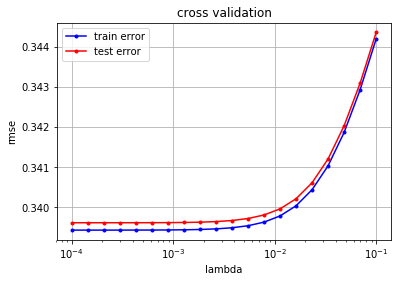

Test best error = 0.3396076229792545for lambda = 0.0001
DEGREE = 2
Lambda = 0.0001
Lambda = 0.0001438449888287663
Lambda = 0.00020691380811147902
Lambda = 0.00029763514416313193
Lambda = 0.00042813323987193956
Lambda = 0.0006158482110660267
Lambda = 0.0008858667904100823
Lambda = 0.0012742749857031334
Lambda = 0.0018329807108324356
Lambda = 0.0026366508987303583
Lambda = 0.00379269019073225
Lambda = 0.005455594781168515
Lambda = 0.007847599703514606
Lambda = 0.011288378916846883
Lambda = 0.01623776739188721
Lambda = 0.023357214690901212
Lambda = 0.03359818286283781
Lambda = 0.04832930238571752
Lambda = 0.06951927961775606
Lambda = 0.1


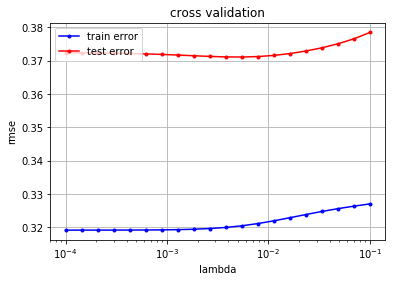

Test best error = 0.37110865087831313for lambda = 0.005455594781168515
DEGREE = 3
Lambda = 0.0001
Lambda = 0.0001438449888287663
Lambda = 0.00020691380811147902
Lambda = 0.00029763514416313193
Lambda = 0.00042813323987193956
Lambda = 0.0006158482110660267
Lambda = 0.0008858667904100823
Lambda = 0.0012742749857031334
Lambda = 0.0018329807108324356
Lambda = 0.0026366508987303583
Lambda = 0.00379269019073225
Lambda = 0.005455594781168515
Lambda = 0.007847599703514606
Lambda = 0.011288378916846883
Lambda = 0.01623776739188721
Lambda = 0.023357214690901212
Lambda = 0.03359818286283781
Lambda = 0.04832930238571752
Lambda = 0.06951927961775606
Lambda = 0.1


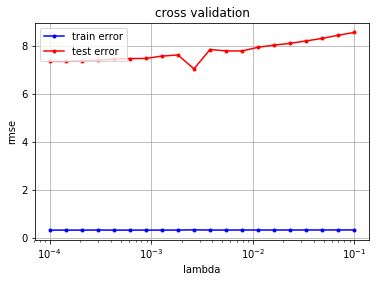

Test best error = 7.033929497562984for lambda = 0.0026366508987303583
DEGREE = 4
Lambda = 0.0001
Lambda = 0.0001438449888287663
Lambda = 0.00020691380811147902
Lambda = 0.00029763514416313193
Lambda = 0.00042813323987193956
Lambda = 0.0006158482110660267
Lambda = 0.0008858667904100823
Lambda = 0.0012742749857031334
Lambda = 0.0018329807108324356
Lambda = 0.0026366508987303583
Lambda = 0.00379269019073225
Lambda = 0.005455594781168515
Lambda = 0.007847599703514606
Lambda = 0.011288378916846883
Lambda = 0.01623776739188721
Lambda = 0.023357214690901212
Lambda = 0.03359818286283781
Lambda = 0.04832930238571752
Lambda = 0.06951927961775606
Lambda = 0.1


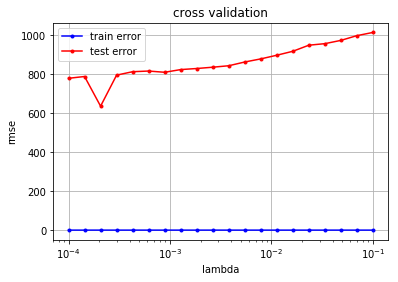

Test best error = 636.0418607181789for lambda = 0.00020691380811147902
Test best error = 779.0154801700834for lambda = 0.0001and degree = 0


In [5]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, tX, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    tX_te=tX[k_indices[k]]
    tX_tr=tX[tr_indice]
    y_te=y[k_indices[k]]
    y_tr=y[tr_indice]
    
    #Build Poly to increase the features
    tX_te_poly=build_poly(tX_te,degree)
    tX_tr_poly=build_poly(tX_tr,degree)
    # ***************************************************
    # ***************************************************
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    [loss_tr,w]=ridge_regression(y_tr,tX_tr_poly,lambda_)
    # ***************************************************
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    loss_te=compute_loss(y_te,tX_te_poly,w)
    # ***************************************************
    return loss_tr, loss_te, w

from plots import cross_validation_visualization

def cross_validation_best_weight():
    seed = 101
    degree = 5
    k_fold = 4
    lambdas = np.logspace(-4, -1, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    weights=[]
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    for d in range(1,degree):
        print("DEGREE = " + str(d))
        rmse_tr_l=[]
        rmse_te_l=[]
        w_l=[]
        for lambda_ in lambdas:
            print("Lambda = "+str(lambda_))
            rmse_tr_k=[]
            rmse_te_k=[]
            w_k=[]
            for k in range(k_fold):
                cv_res=cross_validation(y, tX, k_indices, k, lambda_, d)
                rmse_tr_k.append(cv_res[0])
                rmse_te_k.append(cv_res[1])
                w_l.append(cv_res[2])
            rmse_tr_l.append(np.mean(rmse_tr_k))
            rmse_te_l.append(np.mean(rmse_te_k))
            w_l.append(np.mean(w_l,axis=0))
    # *************************************************** 
        best_index_l=np.argmin(rmse_te_l)
        cross_validation_visualization(lambdas, rmse_tr_l, rmse_te_l,d)
        rmse_tr.append(rmse_tr_l[best_index_l])
        rmse_te.append(rmse_te_l[best_index_l])
        weights.append(w_l[best_index_l])
        print("Test best error = "  + str(rmse_te_l[best_index_l]) + "for lambda = " + str(lambdas[best_index_l]))
    best_index_d=np.argmin(rmse_te)
    print("Test best error = "  + str(rmse_te_best_index_d]) + "for lambda = " + str(lambdas[best_index_d]) + "and degree = "+ str(best_index_d))
    return weights[best_index_d]
weights=cross_validation_best_weight()

# Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [11]:
OUTPUT_PATH = '../data/pred.csv' # TODO: fill in desired name of output file for submission
tX_test=build_poly(tX_test,7)
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)